In [ ]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Permute, Reshape
from keras.layers import Bidirectional, LSTM, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Dropout, Flatten, Lambda, Concatenate, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping, LearningRateScheduler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split
import math
import json
import itertools
import tensorflow as tf
import gc
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


Labels: {'shot': 0, 'sprint': 1, 'jump': 2, 'jog': 3, 'pass': 4}

Order of sensors: ['leftShankAccX' 'leftShankAccY' 'leftShankAccZ' 'leftShankGyroX'
 'leftShankGyroY' 'leftShankGyroZ' 'rightShankAccX' 'rightShankAccY'
 'rightShankAccZ' 'rightShankGyroX' 'rightShankGyroY' 'rightShankGyroZ'
 'leftThighAccX' 'leftThighAccY' 'leftThighAccZ' 'leftThighGyroX'
 'leftThighGyroY' 'leftThighGyroZ' 'rightThighAccX' 'rightThighAccY'
 'rightThighAccZ' 'rightThighGyroX' 'rightThighGyroY' 'rightThighGyroZ'
 'pelvisAccX' 'pelvisAccY' 'pelvisAccZ' 'pelvisGyroX' 'pelvisGyroY'
 'pelvisGyroZ']

Size of dataset: (1215, 30, 500)


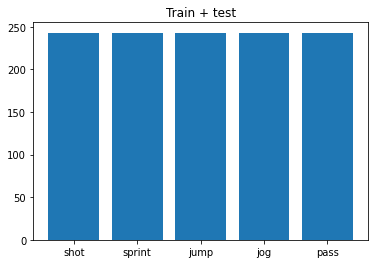

In [ ]:
# Load dataset

# Define settings
sensors_bodypart = 'all'
sensors_type = ['Acc', 'Gyro']
sensors_axis = 'all'
standardize = False
info_dataset = '1s_ssjjp' #1s_ssjjp means windows of 1 second, with classes shots, sprints, jumps, jogs and passes

sensors_bodypart = '-'.join(sensors_bodypart) if isinstance(sensors_bodypart, list) else sensors_bodypart
sensors_type = '-'.join(sensors_type) if isinstance(sensors_type, list) else sensors_type
sensors_axis = '-'.join(sensors_axis) if isinstance(sensors_axis, list) else sensors_axis
standardize = 'standardized' if standardize else 'unstandardized'

in_dir = r'/content/drive/MyDrive/Datasets_thesis/{}/{}_{}_{}_{}/'.format(info_dataset,
                                                                         sensors_bodypart,
                                                                         sensors_type,
                                                                         sensors_axis,
                                                                         standardize)

# Load variables
X_train = np.load(in_dir + 'X_train.npy')
X_test = np.load(in_dir + 'X_test.npy')
y_train = np.load(in_dir + 'y_train.npy')
y_test = np.load(in_dir + 'y_test.npy')
sensors = np.load(in_dir + 'sensors.npy')

with open(in_dir + 'labels_dict.json') as json_file: 
    labels_dict = json.load(json_file) 

# Concatenate train and test dataset
X = np.concatenate((X_train, X_test), axis = 0)
y = np.concatenate((y_train, y_test), axis = 0)

# Order of desired sensors
order_sensors = ['leftShankAccX', 'leftShankAccY', 'leftShankAccZ',
       'leftShankGyroX', 'leftShankGyroY', 'leftShankGyroZ',
       'rightShankAccX', 'rightShankAccY', 'rightShankAccZ',
       'rightShankGyroX', 'rightShankGyroY', 'rightShankGyroZ',
       'leftThighAccX', 'leftThighAccY', 'leftThighAccZ',
       'leftThighGyroX', 'leftThighGyroY', 'leftThighGyroZ',
       'rightThighAccX', 'rightThighAccY', 'rightThighAccZ',
       'rightThighGyroX', 'rightThighGyroY', 'rightThighGyroZ',
       'pelvisAccX', 'pelvisAccY', 'pelvisAccZ', 'pelvisGyroX',
       'pelvisGyroY', 'pelvisGyroZ']
'''
order_sensors = ['leftThighAccX', 'leftThighAccY', 'leftThighAccZ',
       'leftThighGyroX', 'leftThighGyroY', 'leftThighGyroZ',
       'rightThighAccX', 'rightThighAccY', 'rightThighAccZ',
       'rightThighGyroX', 'rightThighGyroY', 'rightThighGyroZ',
       'pelvisAccX', 'pelvisAccY', 'pelvisAccZ', 'pelvisGyroX',
       'pelvisGyroY', 'pelvisGyroZ']
'''
# Take only desired sensors in specified order
ix_order_sensors = []
for s in order_sensors:
  if s in sensors:
    ix_order_sensors.append(np.where(sensors == s)[0][0])
X = X[:,ix_order_sensors,:]
order_sensors = np.array(sensors)[ix_order_sensors]

# Global normalization
normalize = True

print('Labels: {}\n'.format(labels_dict))
print('Order of sensors: {}\n'.format(order_sensors))
print('Size of dataset: {}'.format(X.shape))

plt.figure()
plt.bar(labels_dict.keys(), y.sum(axis=0));
plt.title('Train + test');


In [ ]:
def plot_confusion_matrix(X, y, model, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          savefile=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    predictions = model.predict(X)
    cm = confusion_matrix(y.argmax(axis=1), predictions.argmax(axis=1)) 

    if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      cm = cm * 100
      print("\nNormalized confusion matrix")
    else:
      print('\nConfusion matrix')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt) +'%',
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if savefile:
        plt.savefig(savefile, bbox_inches='tight')
    plt.show()

In [ ]:
def split_per_sensor(x):
    '''Splits x into parts of length 3 (each sensor has 3 axis)'''
    return [x[:,i*3:(i+1)*3,:,:] for i in range(int(x.shape[1]/3))]

In [ ]:
#@title 1DCNN weight sharing
# 1DCNN weight_sharing
def CNN_1D_ws(input_shape, classes):
    """
    1DCNN weight sharing
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)
    classes -- number of classes

    Returns:
    model -- Keras model instance

    """
    ## Build model ##
    # Input
    X_input = Input(shape = input_shape)
    
    # CNN layer
    X = Conv2D(16, (1,5), activation = 'relu')(X_input)
    X = MaxPooling2D((1,4))(X)
    
    # CNN layer
    X = Conv2D(32, (1,5), activation = 'relu')(X)
    X = MaxPooling2D((1,4))(X)
    
    # CNN layer
    X = Conv2D(64, (input_shape[0],1), activation = 'relu')(X)
    
    # Flatten 
    X = Flatten()(X)
    X = Dropout(0.2)(X)
    
    # Dense Layer
    X = Dense(64, activation = 'relu')(X)
    X = Dropout(0.5)(X)
    
    # Output
    X = Dense(classes, activation='softmax')(X)
    
    # Define model
    model = Model(inputs = X_input, outputs = X)

    ## Learning rate schedurer ##
    def lr_step_decay(epoch):
      initial_lrate = 0.001
      drop = 0.75
      epochs_drop = 10
      lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
      return lrate

    return model, lr_step_decay

In [ ]:
#@title 1DCNN per sensor
def CNN_1D_perSensor(input_shape, classes):
    """
    Creates a keras model
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)
    classes -- number of classes

    Returns:
    model -- Keras model instance
    """
    ## Build model
    # Input
    X_input = Input(shape = input_shape)
    
    # Split the input tensor per sensor
    sensors = Lambda(split_per_sensor)(X_input)
    
    # Independent CNN per sensor
    sensors = [Conv2D(16, (1,5), activation = 'relu')(sensor) for sensor in sensors]
    sensors = [MaxPooling2D((1,4))(sensor) for sensor in sensors]
    
    # Independent CNN per sensor
    sensors = [Conv2D(32, (1,5), activation = 'relu')(sensor) for sensor in sensors]
    sensors = [MaxPooling2D((1,4))(sensor) for sensor in sensors]
    
    # Concatenate the feature maps of all sensors
    X = Concatenate(axis = 1)(sensors)
    
    # CNN layer
    X = Conv2D(64, (input_shape[0],1), activation = 'relu')(X)
    
    # Flatten 
    X = Flatten()(X)
    X = Dropout(0.2)(X)
    
    # Dense Layer
    X = Dense(64, activation = 'relu')(X)
    X = Dropout(0.5)(X)
    
    # Output
    X = Dense(classes, activation='softmax')(X)
    
    # Define model
    model = Model(inputs = X_input, outputs = X)


    ## Learning rate scheduler
    def lr_step_decay(epoch):
      initial_lrate = 0.001
      drop = 0.75 # Keep percentage
      epochs_drop = 10
      lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
      return lrate
    
    return model, lr_step_decay

In [ ]:
#@title 1DCNN combined
def CNN_1D_combined(input_shape, classes):
    """
    Creates a keras model
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)
    classes -- number of classes

    Returns:
    model -- Keras model instance
    """
    ## Create model

    # Input
    X_input = Input(shape = input_shape)
    
    # Split the input tensor per sensor
    sensors = Lambda(split_per_sensor)(X_input)
    
    # Independent CNN per sensor
    sensors = [Conv2D(16, (1,5), activation = 'relu')(sensor) for sensor in sensors]
    sensors = [MaxPooling2D((1,4))(sensor) for sensor in sensors]
    
    # Independent CNN per sensor
    sensors = [Conv2D(32, (1,5), activation = 'relu')(sensor) for sensor in sensors]
    sensors = [MaxPooling2D((1,4))(sensor) for sensor in sensors]
    
    # CNN layer with weight sharing
    X = Conv2D(16, (1,5), activation = 'relu')(X_input)
    X = MaxPooling2D((1,4))(X)
    
    # CNN layer with weight sharing
    X = Conv2D(32, (1,5), activation = 'relu')(X)
    X = MaxPooling2D((1,4))(X)

    # Concatenate the feature maps of all sensors and weight sharing part
    sensors.append(X)
    X = Concatenate(axis = 1)(sensors)
    
    # CNN layer
    X = Conv2D(64, (input_shape[0]*2,1), activation = 'relu')(X)
    
    # Flatten 
    X = Flatten()(X)
    X = Dropout(0.2)(X)
    
    # Dense Layer
    X = Dense(64, activation = 'relu')(X)
    X = Dropout(0.5)(X)
    
    # Output
    X = Dense(classes, activation='softmax')(X)
    
    # Define mode
    model = Model(inputs = X_input, outputs = X)
    
      
    ## Learning rate scheduler
    def lr_step_decay(epoch):
        initial_lrate = 0.001
        drop = 0.75 # Keep percentage
        epochs_drop = 10
        lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
        return lrate

    return model, lr_step_decay

In [ ]:
#@title 2DCNN weight sharing
def CNN_2D_ws(input_shape, classes):
    """
    Creates a keras model
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)
    classes -- number of classes

    Returns:
    model -- Keras model instance
    """
    ## Create model
    # Input
    X_input = Input(shape = input_shape)
    
    # CNN layer with weight sharing
    X = Conv2D(16, (3,5), strides = (3,1), activation = 'relu')(X_input)
    X = MaxPooling2D((1,4))(X)
    
    # CNN layer with weight sharing
    X = Conv2D(32, (1,5), activation = 'relu')(X)
    X = MaxPooling2D((1,4))(X)
    
    # CNN layer
    X = Conv2D(16, (int(input_shape[0]/3),1), activation = 'relu')(X)
    
    # Flatten 
    X = Flatten()(X)
    X = Dropout(0.2)(X)
    
    # Dense Layer
    X = Dense(64, activation = 'relu')(X)
    X = Dropout(0.5)(X)
    
    # Output
    X = Dense(classes, activation='softmax')(X)
    
    # Define model
    model = Model(inputs = X_input, outputs = X)
    

    ## Learning rate scheduler
    def lr_step_decay(epoch):
      initial_lrate = 0.001
      drop = 0.75 # Keep percentage
      epochs_drop = 10
      lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
      return lrate

    return model, lr_step_decay

In [ ]:
#@title 2DCNN per sensor
def CNN_2D_perSensor(input_shape, classes):
    """
    Creates a keras model
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)
    classes -- number of classes

    Returns:
    model -- Keras model instance
    """
    ## Create model
    #Input
    X_input = Input(shape = input_shape)
    
    # Split the input tensor per sensor
    sensors = Lambda(split_per_sensor)(X_input)
    
    # Independent CNN per sensor
    sensors = [Conv2D(16, (3,5), activation = 'relu')(sensor) for sensor in sensors]
    sensors = [MaxPooling2D((1,4))(sensor) for sensor in sensors]
    
    # Independent CNN per sensor
    sensors = [Conv2D(16, (1,5), activation = 'relu')(sensor) for sensor in sensors]
    sensors = [MaxPooling2D((1,4))(sensor) for sensor in sensors]
    
    # Concatenate the feature maps of all sensors
    X = Concatenate(axis = 1)(sensors)
    
    # CNN layer
    X = Conv2D(32, (int(input_shape[0]/3),1), activation = 'relu')(X)
    
    # Flatten 
    X = Flatten()(X)
    X = Dropout(0.2)(X)
    
    # Dense Layer
    X = Dense(64, activation = 'relu')(X)
    X = Dropout(0.5)(X)
    
    # Output
    X = Dense(classes, activation='softmax')(X)
    
    # Define model
    model = Model(inputs = X_input, outputs = X)


    ## Learning rate scheduler
    def lr_step_decay(epoch):
      initial_lrate = 0.001
      drop = 0.75 # Keep percentage
      epochs_drop = 10
      lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
      return lrate

    return model, lr_step_decay

In [ ]:
#@title 2DCNN all signals
def CNN_2D_allSignals(input_shape, classes):
    """
    Creates a keras model
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)
    classes -- number of classes

    Returns:
    model -- Keras model instance
    """
    ## Create model
    # Input
    X_input = Input(shape = input_shape)
    
    # CNN layer with weight sharing
    X = Conv2D(32, (input_shape[0],5), activation = 'relu')(X_input)
    X = MaxPooling2D((1,4))(X)
    
    # CNN layer with weight sharing
    X = Conv2D(32, (1,5), activation = 'relu')(X)
    X = MaxPooling2D((1,4))(X)
    
    # Flatten 
    X = Flatten()(X)
    X = Dropout(0.2)(X)
    
    # Dense Layer
    X = Dense(64, activation = 'relu')(X)
    X = Dropout(0.5)(X)
    
    # Output
    X = Dense(classes, activation='softmax')(X)
    
    # Define model
    model = Model(inputs = X_input, outputs = X)


    ## Learning rate scheduler
    def lr_step_decay(epoch):
      initial_lrate = 0.001
      drop = 0.75 # Keep percentage
      epochs_drop = 10
      lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
      return lrate
    
    return model, lr_step_decay

In [ ]:
#@title 2DCNN combined
def CNN_2D_combined(input_shape, classes):
    """
    Creates a keras model
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)
    classes -- number of classes

    Returns:
    model -- Keras model instance
    """
    ## Create model
    # Input
    X_input = Input(shape = input_shape)
    
    # Split the input tensor per sensor
    sensors = Lambda(split_per_sensor)(X_input)
    
    # Independent CNN per sensor
    sensors = [Conv2D(16, (3,5), activation = 'relu')(sensor) for sensor in sensors]
    sensors = [MaxPooling2D((1,4))(sensor) for sensor in sensors]
    
    # Independent CNN per sensor
    sensors = [Conv2D(32, (1,5), activation = 'relu')(sensor) for sensor in sensors]
    sensors = [MaxPooling2D((1,4))(sensor) for sensor in sensors]
    
    
    # CNN layer with weight sharing
    normal = Conv2D(16, (3,5), strides = (3,1), activation = 'relu')(X_input)
    normal = MaxPooling2D((1,4))(normal)
    
    # CNN layer with weight sharing
    normal = Conv2D(32, (1,5), activation = 'relu')(normal)
    normal = MaxPooling2D((1,4))(normal)
    
    
    # CNN layer with weight sharing all signals
    all_signals = Conv2D(32, (input_shape[0],5), activation = 'relu')(X_input)
    all_signals = MaxPooling2D((1,4))(all_signals)
    
    # CNN layer with weight sharing all signals
    all_signals = Conv2D(32, (1,5), activation = 'relu')(all_signals)
    all_signals = MaxPooling2D((1,4))(all_signals)
    
    # Concatenate all feature maps
    sensors.append(normal)
    sensors.append(all_signals)
    X = Concatenate(axis = 1)(sensors)
    
    # CNN layer
    X = Conv2D(64, (int(1+2*input_shape[0]/3),1), activation = 'relu')(X)
    
    # Flatten 
    X = Flatten()(X)
    X = Dropout(0.2)(X)
    
    # Dense Layer
    X = Dense(64, activation = 'relu')(X)
    X = Dropout(0.5)(X)
    
    # Output
    X = Dense(classes, activation='softmax')(X)
    
    # Define model
    model = Model(inputs = X_input, outputs = X)


    ## Learning rate scheduler
    def lr_step_decay(epoch):
      initial_lrate = 0.001
      drop = 0.75 # Keep percentage
      epochs_drop = 10
      lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
      return lrate
    
    return model, lr_step_decay

In [ ]:
#@title 1DCNN weight sharing LSTM
def CNN_1D_ws_LSTM(input_shape, classes):
    """
    Creates a keras model
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)
    classes -- number of classes

    Returns:
    model -- Keras model instance
    """
    ## Create model
    # Input
    X_input = Input(shape = input_shape)
    
    # CNN layer
    X = Conv2D(16, (1,5), activation = 'relu')(X_input)
    X = MaxPooling2D((1,4))(X)
    
    # CNN layer
    X = Conv2D(32, (1,5), activation = 'relu')(X)
    X = MaxPooling2D((1,4))(X)

    # CNN layer to prepare for LSTM
    last_kernels = 128
    X = Conv2D(last_kernels, (input_shape[0],1), activation = 'relu')(X)
    X = Permute((2, 1, 3))(X)
    X = Reshape((-1, last_kernels))(X)

    # LSTM layer
    X = LSTM(128, return_sequences=True)(X)
  
    # LSTM layer
    X = LSTM(128, return_sequences=False)(X)
    X = Dropout(0.3)(X)

    # Dense Layer
    X = Dense(128, activation = 'relu')(X)
    X = Dropout(0.5)(X)
    
    # Output
    X = Dense(classes, activation='softmax')(X)
    
    # Define model
    model = Model(inputs = X_input, outputs = X)
    

    def lr_step_decay(epoch):
      initial_lrate = 0.0005
      drop = 0.75 # Keep percentage
      epochs_drop = 10
      lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
      return lrate

    return model, lr_step_decay

In [ ]:
#@title 1DCNN per sensor LSTM
def CNN_1D_perSensor_LSTM(input_shape, classes):
    """
    Creates a keras model
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)
    classes -- number of classes

    Returns:
    model -- Keras model instance
    """
    ## Build model
    # Input
    X_input = Input(shape = input_shape)
    
    # Split the input tensor per sensor
    sensors = Lambda(split_per_sensor)(X_input)
    
    # Independent CNN per sensor
    sensors = [Conv2D(16, (1,5), activation = 'relu')(sensor) for sensor in sensors]
    sensors = [MaxPooling2D((1,4))(sensor) for sensor in sensors]
    
    # Independent CNN per sensor
    sensors = [Conv2D(32, (1,5), activation = 'relu')(sensor) for sensor in sensors]
    sensors = [MaxPooling2D((1,4))(sensor) for sensor in sensors]
    
    # Concatenate the feature maps of all sensors
    X = Concatenate(axis = 1)(sensors)

    # CNN layer to prepare for LSTM
    last_kernels = 128
    X = Conv2D(last_kernels, (input_shape[0],1), activation = 'relu')(X)
    X = Permute((2, 1, 3))(X)
    X = Reshape((-1, last_kernels))(X)

    # LSTM layer
    X = LSTM(128, return_sequences=True)(X)
  
    # LSTM layer
    X = LSTM(128, return_sequences=False)(X)
    X = Dropout(0.3)(X)

    # Dense Layer
    X = Dense(128, activation = 'relu')(X)
    X = Dropout(0.5)(X)
    
    # Output
    X = Dense(classes, activation='softmax')(X)
    
    # Define model
    model = Model(inputs = X_input, outputs = X)


    # Learning rate scheduler
    def lr_step_decay(epoch):
      initial_lrate = 0.0005
      drop = 0.75 # Keep percentage
      epochs_drop = 10
      lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
      return lrate
    
    return model, lr_step_decay

In [ ]:
#@title 1DCNN combined LSTM
def CNN_1D_combined_LSTM(input_shape, classes):
    """
    Creates a keras model
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)
    classes -- number of classes

    Returns:
    model -- Keras model instance
    """
    ## Build model
    # Input
    X_input = Input(shape = input_shape)
    
    # Split the input tensor per sensor
    sensors = Lambda(split_per_sensor)(X_input)
    
    # Independent CNN per sensor
    sensors = [Conv2D(16, (1,5), activation = 'relu')(sensor) for sensor in sensors]
    sensors = [MaxPooling2D((1,4))(sensor) for sensor in sensors]
    
    # Independent CNN per sensor
    sensors = [Conv2D(32, (1,5), activation = 'relu')(sensor) for sensor in sensors]
    sensors = [MaxPooling2D((1,4))(sensor) for sensor in sensors]
    
    # CNN layer with weight sharing
    X = Conv2D(16, (1,5), activation = 'relu')(X_input)
    X = MaxPooling2D((1,4))(X)
    
    # CNN layer with weight sharing
    X = Conv2D(32, (1,5), activation = 'relu')(X)
    X = MaxPooling2D((1,4))(X)
    
    # Concatenate the feature maps of all sensors
    sensors.append(X)
    X = Concatenate(axis = 1)(sensors)

    # CNN layer to prepare for LSTM
    last_kernels = 128
    X = Conv2D(last_kernels, (input_shape[0]*2,1), activation = 'relu')(X)
    X = Permute((2, 1, 3))(X)
    X = Reshape((-1, last_kernels))(X)

    # LSTM layer
    X = LSTM(128, return_sequences=True)(X)
  
    # LSTM layer
    X = LSTM(128, return_sequences=False)(X)
    X = Dropout(0.3)(X)

    # Dense Layer
    X = Dense(128, activation = 'relu')(X)
    X = Dropout(0.5)(X)
    
    # Output
    X = Dense(classes, activation='softmax')(X)
    
    # Define model
    model = Model(inputs = X_input, outputs = X)


    ## Learning rate scheduler
    def lr_step_decay(epoch):
      initial_lrate = 0.0005
      drop = 0.75 # Keep percentage
      epochs_drop = 10
      lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
      return lrate
    
    return model, lr_step_decay

In [ ]:
#@title 2DCNN weight sharing LSTM
def CNN_2D_ws_LSTM(input_shape, classes):
    """
    Creates a keras model
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)
    classes -- number of classes

    Returns:
    model -- Keras model instance
    """
    ## Build model
    # Input
    X_input = Input(shape = input_shape)
    
    # CNN layer with weight sharing
    X = Conv2D(32, (3,5), strides = (3,1), activation = 'relu')(X_input)
    X = MaxPooling2D((1,4))(X)
    
    # CNN layer with weight sharing
    X = Conv2D(64, (1,5), activation = 'relu')(X)
    X = MaxPooling2D((1,4))(X)

    # CNN layer to prepare for LSTM
    last_kernels = 128
    X = Conv2D(last_kernels, (int(input_shape[0]/3),1), activation = 'relu')(X)
    X = Permute((2, 1, 3))(X)
    X = Reshape((-1, last_kernels))(X)

    # LSTM layer
    X = LSTM(128, return_sequences=True)(X)
  
    # LSTM layer
    X = LSTM(128, return_sequences=False)(X)
    X = Dropout(0.3)(X)

    # Dense Layer
    X = Dense(128, activation = 'relu')(X)
    X = Dropout(0.5)(X)
    
    # Output
    X = Dense(classes, activation='softmax')(X)
    
    # Define model
    model = Model(inputs = X_input, outputs = X)


    ## Learning rate scheduler
    def lr_step_decay(epoch):
      initial_lrate = 0.0005
      drop = 0.75 # Keep percentage
      epochs_drop = 10
      lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
      return lrate
    
    return model, lr_step_decay

In [ ]:
#@title 2DCNN per sensor LSTM
def CNN_2D_perSensor_LSTM(input_shape, classes):
    """
    Creates a keras model
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)
    classes -- number of classes

    Returns:
    model -- Keras model instance
    """
    ## Build model
    # Input
    X_input = Input(shape = input_shape)
    
    # Split the input tensor per sensor
    sensors = Lambda(split_per_sensor)(X_input)
    
    # Independent CNN per sensor
    sensors = [Conv2D(32, (3,5), activation = 'relu')(sensor) for sensor in sensors]
    sensors = [MaxPooling2D((1,4))(sensor) for sensor in sensors]
    
    # Independent CNN per sensor
    sensors = [Conv2D(64, (1,5), activation = 'relu')(sensor) for sensor in sensors]
    sensors = [MaxPooling2D((1,4))(sensor) for sensor in sensors]
    
    # Concatenate the feature maps of all sensors
    X = Concatenate(axis = 1)(sensors)

    # CNN layer to prepare for LSTM
    last_kernels = 128
    X = Conv2D(last_kernels, (int(input_shape[0]/3),1), activation = 'relu')(X)
    X = Permute((2, 1, 3))(X)
    X = Reshape((-1, last_kernels))(X)

    # LSTM layer
    X = LSTM(128, return_sequences=True)(X)
  
    # LSTM layer
    X = LSTM(128, return_sequences=False)(X)
    X = Dropout(0.3)(X)

    # Dense Layer
    X = Dense(128, activation = 'relu')(X)
    X = Dropout(0.5)(X)
    
    # Output
    X = Dense(classes, activation='softmax')(X)
    
    # Define model
    model = Model(inputs = X_input, outputs = X)
    

    ## Learning rate scheduler
    def lr_step_decay(epoch):
      initial_lrate = 0.0005
      drop = 0.75 # Keep percentage
      epochs_drop = 10
      lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
      return lrate

    return model, lr_step_decay

In [ ]:
#@title 2DCNN all signals LSTM
def CNN_2D_allSignals_LSTM(input_shape, classes):
    """
    Creates a keras model
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)
    classes -- number of classes

    Returns:
    model -- Keras model instance
    """
    ## Build model
    # Input
    X_input = Input(shape = input_shape)

    # CNN layer with weight sharing
    X = Conv2D(32, (input_shape[0],5), activation = 'relu')(X_input)
    X = MaxPooling2D((1,4))(X)

    last_kernels = 64
    # CNN layer with weight sharing
    X = Conv2D(last_kernels, (1,5), activation = 'relu')(X)
    X = MaxPooling2D((1,4))(X)

    # Format tensor for LSTM
    X = Permute((2, 1, 3))(X)
    X = Reshape((-1, last_kernels))(X)

    # LSTM layer
    X = LSTM(128, return_sequences=True)(X)
  
    # LSTM layer
    X = LSTM(128, return_sequences=False)(X)
    X = Dropout(0.3)(X)

    # Dense Layer
    X = Dense(128, activation = 'relu')(X)
    X = Dropout(0.5)(X)
    
    # Output
    X = Dense(classes, activation='softmax')(X)
    
    # Define model
    model = Model(inputs = X_input, outputs = X)


    ## Learning rate scheduler
    def lr_step_decay(epoch):
      initial_lrate = 0.0005
      drop = 0.75 # Keep percentage
      epochs_drop = 10
      lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
      return lrate
    
    return model, lr_step_decay

In [ ]:
#@title 2DCNN combined LSTM
def CNN_2D_combined_LSTM(input_shape, classes):
    """
    Creates a keras model
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)
    classes -- number of classes

    Returns:
    model -- Keras model instance
    """
    ## Build model
    # Input
    X_input = Input(shape = input_shape)

    # Split the input tensor per sensor
    sensors = Lambda(split_per_sensor)(X_input)
    
    # Independent CNN per sensor
    sensors = [Conv2D(32, (3,5), activation = 'relu')(sensor) for sensor in sensors]
    sensors = [MaxPooling2D((1,4))(sensor) for sensor in sensors]
    
    # Independent CNN per sensor
    sensors = [Conv2D(64, (1,5), activation = 'relu')(sensor) for sensor in sensors]
    sensors = [MaxPooling2D((1,4))(sensor) for sensor in sensors]
    
    
    # CNN layer with weight sharing
    normal = Conv2D(32, (3,5), strides = (3,1), activation = 'relu')(X_input)
    normal = MaxPooling2D((1,4))(normal)
    
    # CNN layer with weight sharing
    normal = Conv2D(64, (1,5), activation = 'relu')(normal)
    normal = MaxPooling2D((1,4))(normal)
    
    
    # CNN layer with weight sharing all signals
    all_signals = Conv2D(32, (input_shape[0],5), activation = 'relu')(X_input)
    all_signals = MaxPooling2D((1,4))(all_signals)
    
    # CNN layer with weight sharing all signals
    all_signals = Conv2D(64, (1,5), activation = 'relu')(all_signals)
    all_signals = MaxPooling2D((1,4))(all_signals)
    

    # Concatenate all feature maps
    sensors.append(normal)
    sensors.append(all_signals)
    X = Concatenate(axis = 1)(sensors)
    
    # CNN layer to prepare for LSTM
    last_kernels = 128
    X = Conv2D(last_kernels, (int(1+2*input_shape[0]/3),1), activation = 'relu')(X)
    X = Permute((2, 1, 3))(X)
    X = Reshape((-1, last_kernels))(X)

    # LSTM layer
    X = LSTM(128, return_sequences=True)(X)
  
    # LSTM layer
    X = LSTM(128, return_sequences=False)(X)
    X = Dropout(0.3)(X)

    # Dense Layer
    X = Dense(128, activation = 'relu')(X)
    X = Dropout(0.5)(X)
    
    # Output
    X = Dense(classes, activation='softmax')(X)
    
    # Define model
    model = Model(inputs = X_input, outputs = X)


    ## Learning rate scheduler
    def lr_step_decay(epoch):
      initial_lrate = 0.0005
      drop = 0.75 # Keep percentage
      epochs_drop = 10
      lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
      return lrate
    
    return model, lr_step_decay

In [ ]:
#@title 1DCNN weight sharing bLSTM
def CNN_1D_ws_bLSTM(input_shape, classes):
    """
    Creates a keras model
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)
    classes -- number of classes

    Returns:
    model -- Keras model instance
    """
    ## Create model
    # Input
    X_input = Input(shape = input_shape)
    
    # CNN layer
    X = Conv2D(16, (1,5), activation = 'relu')(X_input)
    X = MaxPooling2D((1,4))(X)
    
    # CNN layer
    X = Conv2D(32, (1,5), activation = 'relu')(X)
    X = MaxPooling2D((1,4))(X)

    # CNN layer to prepare for LSTM
    last_kernels = 128
    X = Conv2D(last_kernels, (input_shape[0],1), activation = 'relu')(X)
    X = Permute((2, 1, 3))(X)
    X = Reshape((-1, last_kernels))(X)

    # LSTM layer
    X = Bidirectional(LSTM(128, return_sequences=True))(X)
  
    # LSTM layer
    X = Bidirectional(LSTM(128, return_sequences=False))(X)
    X = Dropout(0.3)(X)

    # Dense Layer
    X = Dense(128, activation = 'relu')(X)
    X = Dropout(0.5)(X)
    
    # Output
    X = Dense(classes, activation='softmax')(X)
    
    # Define model
    model = Model(inputs = X_input, outputs = X)
    

    def lr_step_decay(epoch):
      initial_lrate = 0.0005
      drop = 0.75 # Keep percentage
      epochs_drop = 10
      lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
      return lrate

    return model, lr_step_decay

In [ ]:
#@title 1DCNN per sensor bLSTM
def CNN_1D_perSensor_bLSTM(input_shape, classes):
    """
    Creates a keras model
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)
    classes -- number of classes

    Returns:
    model -- Keras model instance
    """
    ## Build model
    # Input
    X_input = Input(shape = input_shape)
    
    # Split the input tensor per sensor
    sensors = Lambda(split_per_sensor)(X_input)
    
    # Independent CNN per sensor
    sensors = [Conv2D(16, (1,5), activation = 'relu')(sensor) for sensor in sensors]
    sensors = [MaxPooling2D((1,4))(sensor) for sensor in sensors]
    
    # Independent CNN per sensor
    sensors = [Conv2D(32, (1,5), activation = 'relu')(sensor) for sensor in sensors]
    sensors = [MaxPooling2D((1,4))(sensor) for sensor in sensors]
    
    # Concatenate the feature maps of all sensors
    X = Concatenate(axis = 1)(sensors)

    # CNN layer to prepare for LSTM
    last_kernels = 128
    X = Conv2D(last_kernels, (input_shape[0],1), activation = 'relu')(X)
    X = Permute((2, 1, 3))(X)
    X = Reshape((-1, last_kernels))(X)

    # LSTM layer
    X = Bidirectional(LSTM(128, return_sequences=True))(X)
  
    # LSTM layer
    X = Bidirectional(LSTM(128, return_sequences=False))(X)
    X = Dropout(0.3)(X)

    # Dense Layer
    X = Dense(128, activation = 'relu')(X)
    X = Dropout(0.5)(X)
    
    # Output
    X = Dense(classes, activation='softmax')(X)
    
    # Define model
    model = Model(inputs = X_input, outputs = X)


    # Learning rate scheduler
    def lr_step_decay(epoch):
      initial_lrate = 0.0005
      drop = 0.75 # Keep percentage
      epochs_drop = 10
      lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
      return lrate
    
    return model, lr_step_decay

In [ ]:
#@title 1DCNN combined bLSTM
def CNN_1D_combined_bLSTM(input_shape, classes):
    """
    Creates a keras model
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)
    classes -- number of classes

    Returns:
    model -- Keras model instance
    """
    ## Build model
    # Input
    X_input = Input(shape = input_shape)
    
    # Split the input tensor per sensor
    sensors = Lambda(split_per_sensor)(X_input)
    
    # Independent CNN per sensor
    sensors = [Conv2D(16, (1,5), activation = 'relu')(sensor) for sensor in sensors]
    sensors = [MaxPooling2D((1,4))(sensor) for sensor in sensors]
    
    # Independent CNN per sensor
    sensors = [Conv2D(32, (1,5), activation = 'relu')(sensor) for sensor in sensors]
    sensors = [MaxPooling2D((1,4))(sensor) for sensor in sensors]
    
    # CNN layer with weight sharing
    X = Conv2D(16, (1,5), activation = 'relu')(X_input)
    X = MaxPooling2D((1,4))(X)
    
    # CNN layer with weight sharing
    X = Conv2D(32, (1,5), activation = 'relu')(X)
    X = MaxPooling2D((1,4))(X)
    
    # Concatenate the feature maps of all sensors
    sensors.append(X)
    X = Concatenate(axis = 1)(sensors)

    # CNN layer to prepare for LSTM
    last_kernels = 128
    X = Conv2D(last_kernels, (input_shape[0]*2,1), activation = 'relu')(X)
    X = Permute((2, 1, 3))(X)
    X = Reshape((-1, last_kernels))(X)

    # LSTM layer
    X = Bidirectional(LSTM(128, return_sequences=True))(X)
  
    # LSTM layer
    X = Bidirectional(LSTM(128, return_sequences=False))(X)
    X = Dropout(0.3)(X)

    # Dense Layer
    X = Dense(128, activation = 'relu')(X)
    X = Dropout(0.5)(X)
    
    # Output
    X = Dense(classes, activation='softmax')(X)
    
    # Define model
    model = Model(inputs = X_input, outputs = X)


    ## Learning rate scheduler
    def lr_step_decay(epoch):
      initial_lrate = 0.0005
      drop = 0.75 # Keep percentage
      epochs_drop = 10
      lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
      return lrate
    
    return model, lr_step_decay

In [ ]:
#@title 2DCNN weight sharing bLSTM
def CNN_2D_ws_bLSTM(input_shape, classes):
    """
    Creates a keras model
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)
    classes -- number of classes

    Returns:
    model -- Keras model instance
    """
    ## Build model
    # Input
    X_input = Input(shape = input_shape)
    
    # CNN layer with weight sharing
    X = Conv2D(32, (3,5), strides = (3,1), activation = 'relu')(X_input)
    X = MaxPooling2D((1,4))(X)
    
    # CNN layer with weight sharing
    X = Conv2D(64, (1,5), activation = 'relu')(X)
    X = MaxPooling2D((1,4))(X)

    # CNN layer to prepare for LSTM
    last_kernels = 128
    X = Conv2D(last_kernels, (int(input_shape[0]/3),1), activation = 'relu')(X)
    X = Permute((2, 1, 3))(X)
    X = Reshape((-1, last_kernels))(X)

    # LSTM layer
    X = Bidirectional(LSTM(128, return_sequences=True))(X)
  
    # LSTM layer
    X = Bidirectional(LSTM(128, return_sequences=False))(X)
    X = Dropout(0.3)(X)

    # Dense Layer
    X = Dense(128, activation = 'relu')(X)
    X = Dropout(0.5)(X)
    
    # Output
    X = Dense(classes, activation='softmax')(X)
    
    # Define model
    model = Model(inputs = X_input, outputs = X)


    ## Learning rate scheduler
    def lr_step_decay(epoch):
      initial_lrate = 0.0005
      drop = 0.75 # Keep percentage
      epochs_drop = 10
      lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
      return lrate
    
    return model, lr_step_decay

In [ ]:
#@title 2DCNN per sensor bLSTM
def CNN_2D_perSensor_bLSTM(input_shape, classes):
    """
    Creates a keras model
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)
    classes -- number of classes

    Returns:
    model -- Keras model instance
    """
    ## Build model
    # Input
    X_input = Input(shape = input_shape)
    
    # Split the input tensor per sensor
    sensors = Lambda(split_per_sensor)(X_input)
    
    # Independent CNN per sensor
    sensors = [Conv2D(32, (3,5), activation = 'relu')(sensor) for sensor in sensors]
    sensors = [MaxPooling2D((1,4))(sensor) for sensor in sensors]
    
    # Independent CNN per sensor
    sensors = [Conv2D(64, (1,5), activation = 'relu')(sensor) for sensor in sensors]
    sensors = [MaxPooling2D((1,4))(sensor) for sensor in sensors]
    
    # Concatenate the feature maps of all sensors
    X = Concatenate(axis = 1)(sensors)

    # CNN layer to prepare for LSTM
    last_kernels = 128
    X = Conv2D(last_kernels, (int(input_shape[0]/3),1), activation = 'relu')(X)
    X = Permute((2, 1, 3))(X)
    X = Reshape((-1, last_kernels))(X)

    # LSTM layer
    X = Bidirectional(LSTM(128, return_sequences=True))(X)
  
    # LSTM layer
    X = Bidirectional(LSTM(128, return_sequences=False))(X)
    X = Dropout(0.3)(X)

    # Dense Layer
    X = Dense(128, activation = 'relu')(X)
    X = Dropout(0.5)(X)
    
    # Output
    X = Dense(classes, activation='softmax')(X)
    
    # Define model
    model = Model(inputs = X_input, outputs = X)
    

    ## Learning rate scheduler
    def lr_step_decay(epoch):
      initial_lrate = 0.0005
      drop = 0.75 # Keep percentage
      epochs_drop = 10
      lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
      return lrate

    return model, lr_step_decay

In [ ]:
#@title 2DCNN all signals bLSTM
def CNN_2D_allSignals_bLSTM(input_shape, classes):
    """
    Creates a keras model
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)
    classes -- number of classes

    Returns:
    model -- Keras model instance
    """
    ## Build model
    # Input
    X_input = Input(shape = input_shape)

    # CNN layer with weight sharing
    X = Conv2D(32, (input_shape[0],5), activation = 'relu')(X_input)
    X = MaxPooling2D((1,4))(X)

    last_kernels = 64
    # CNN layer with weight sharing
    X = Conv2D(last_kernels, (1,5), activation = 'relu')(X)
    X = MaxPooling2D((1,4))(X)

    # Format tensor for LSTM
    X = Permute((2, 1, 3))(X)
    X = Reshape((-1, last_kernels))(X)

    # LSTM layer
    X = Bidirectional(LSTM(128, return_sequences=True))(X)
  
    # LSTM layer
    X = Bidirectional(LSTM(128, return_sequences=False))(X)
    X = Dropout(0.3)(X)

    # Dense Layer
    X = Dense(128, activation = 'relu')(X)
    X = Dropout(0.5)(X)
    
    # Output
    X = Dense(classes, activation='softmax')(X)
    
    # Define model
    model = Model(inputs = X_input, outputs = X)


    ## Learning rate scheduler
    def lr_step_decay(epoch):
      initial_lrate = 0.0005
      drop = 0.75 # Keep percentage
      epochs_drop = 10
      lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
      return lrate
    
    return model, lr_step_decay

In [ ]:
#@title 2DCNN combined bLSTM
def CNN_2D_combined_bLSTM(input_shape, classes):
    """
    Creates a keras model
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)
    classes -- number of classes

    Returns:
    model -- Keras model instance
    """
    ## Build model
    # Input
    X_input = Input(shape = input_shape)

    # Split the input tensor per sensor
    sensors = Lambda(split_per_sensor)(X_input)
    
    # Independent CNN per sensor
    sensors = [Conv2D(32, (3,5), activation = 'relu')(sensor) for sensor in sensors]
    sensors = [MaxPooling2D((1,4))(sensor) for sensor in sensors]
    
    # Independent CNN per sensor
    sensors = [Conv2D(64, (1,5), activation = 'relu')(sensor) for sensor in sensors]
    sensors = [MaxPooling2D((1,4))(sensor) for sensor in sensors]
    
    
    # CNN layer with weight sharing
    normal = Conv2D(32, (3,5), strides = (3,1), activation = 'relu')(X_input)
    normal = MaxPooling2D((1,4))(normal)
    
    # CNN layer with weight sharing
    normal = Conv2D(64, (1,5), activation = 'relu')(normal)
    normal = MaxPooling2D((1,4))(normal)
    
    
    # CNN layer with weight sharing all signals
    all_signals = Conv2D(32, (input_shape[0],5), activation = 'relu')(X_input)
    all_signals = MaxPooling2D((1,4))(all_signals)
    
    # CNN layer with weight sharing all signals
    all_signals = Conv2D(64, (1,5), activation = 'relu')(all_signals)
    all_signals = MaxPooling2D((1,4))(all_signals)
    

    # Concatenate all feature maps
    sensors.append(normal)
    sensors.append(all_signals)
    X = Concatenate(axis = 1)(sensors)
    
    # CNN layer to prepare for LSTM
    last_kernels = 128
    X = Conv2D(last_kernels, (int(1+2*input_shape[0]/3),1), activation = 'relu')(X)
    X = Permute((2, 1, 3))(X)
    X = Reshape((-1, last_kernels))(X)

    # LSTM layer
    X = Bidirectional(LSTM(128, return_sequences=True))(X)
  
    # LSTM layer
    X = Bidirectional(LSTM(128, return_sequences=False))(X)
    X = Dropout(0.3)(X)

    # Dense Layer
    X = Dense(128, activation = 'relu')(X)
    X = Dropout(0.5)(X)
    
    # Output
    X = Dense(classes, activation='softmax')(X)
    
    # Define model
    model = Model(inputs = X_input, outputs = X)


    ## Learning rate scheduler
    def lr_step_decay(epoch):
      initial_lrate = 0.0005
      drop = 0.75 # Keep percentage
      epochs_drop = 10
      lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
      return lrate
    
    return model, lr_step_decay

In [ ]:
#@title LSTM
def lstm(input_shape, classes):
    """
    Creates a keras model
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)
    classes -- number of classes

    Returns:
    model -- Keras model instance
    """
    ## Build model
    # Input
    X_input = Input(shape = input_shape)
    
    # LSTM
    X = LSTM(128, return_sequences=True)(X_input)
    
    # LSTM
    X = LSTM(128, return_sequences=False)(X)
    X = Dropout(0.2)(X)
    
    # Dense Layer
    X = Dense(64, activation = 'relu')(X)
    X = Dropout(0.5)(X)
    X = Dense(64, activation = 'relu')(X)
    X = Dropout(0.3)(X)
    
    # Output
    X = Dense(classes, activation='softmax')(X)
    
    # Define model
    model = Model(inputs = X_input, outputs = X)
    

    ## Learning rate scheduler 
    def lr_step_decay(epoch):
      initial_lrate = 0.001
      drop = 0.50 # Keep percentage
      epochs_drop = 20
      lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
      return lrate

    return model, lr_step_decay

In [ ]:
#@title bLSTM
def blstm(input_shape, classes):
    """
    Creates a keras model
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)
    classes -- number of classes

    Returns:
    model -- Keras model instance
    """
    ## Build model
    # Input
    X_input = Input(shape = input_shape)
    
    # bLSTM
    X = Bidirectional(LSTM(128, return_sequences=True))(X_input)
    
    # bLSTM
    X = Bidirectional(LSTM(128, return_sequences=False))(X)
    X = Dropout(0.2)(X)
    
    # Dense Layer
    X = Dense(64, activation = 'relu')(X)
    X = Dropout(0.5)(X)
    X = Dense(64, activation = 'relu')(X)
    X = Dropout(0.3)(X)
    
    # Output
    X = Dense(classes, activation='softmax')(X)
    
    # Define model
    model = Model(inputs = X_input, outputs = X)


    ## Learning rate scheduler
    def lr_step_decay(epoch):
      initial_lrate = 0.001
      drop = 0.50 # Keep percentage
      epochs_drop = 20
      lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
      return lrate

    return model, lr_step_decay

In [ ]:
model_function_names_CNN = {'1DCNN_ws': 'CNN_1D_ws',
                            '1DCNN_perSensor': 'CNN_1D_perSensor', 
                            '1DCNN_combined': 'CNN_1D_combined',
                            '2DCNN_ws': 'CNN_2D_ws',
                            '2DCNN_perSensor': 'CNN_2D_perSensor',
                            '2DCNN_allSignals': 'CNN_2D_allSignals',
                            '2DCNN_combined': 'CNN_2D_combined',
                            '1DCNN_ws_LSTM': 'CNN_1D_ws_LSTM',
                            '1DCNN_perSensor_LSTM': 'CNN_1D_perSensor_LSTM',
                            '1DCNN_combined_LSTM': 'CNN_1D_combined_LSTM',
                            '2DCNN_ws_LSTM': 'CNN_2D_ws_LSTM',
                            '2DCNN_perSensor_LSTM': 'CNN_2D_perSensor_LSTM',
                            '2DCNN_allSignals_LSTM': 'CNN_2D_allSignals_LSTM',
                            '2DCNN_combined_LSTM':'CNN_2D_combined_LSTM',
                            '1DCNN_ws_bLSTM': 'CNN_1D_ws_bLSTM',
                            '1DCNN_perSensor_bLSTM': 'CNN_1D_perSensor_bLSTM',
                            '1DCNN_combined_bLSTM': 'CNN_1D_combined_bLSTM',
                            '2DCNN_ws_bLSTM': 'CNN_2D_ws_bLSTM',
                            '2DCNN_perSensor_bLSTM': 'CNN_2D_perSensor_bLSTM',
                            '2DCNN_allSignals_bLSTM': 'CNN_2D_allSignals_bLSTM',
                            '2DCNN_combined_bLSTM': 'CNN_2D_combined_bLSTM'}
  
model_function_names_RNN = {'LSTM': 'lstm', 
                            'bLSTM': 'blstm'}

In [ ]:
def createModel(name_model, X, y):
  '''
  Create model.
  Returns the model and the learning rate scheduler
  '''
  tf.compat.v1.reset_default_graph()
  tf.keras.backend.clear_session()
  _ = gc.collect()

  # Models with CNN 
  if name_model in model_function_names_CNN: 
    model, lr = eval(model_function_names_CNN[name_model])((X.shape[1], X.shape[2], 1), y.shape[1])
  # Models without CNN. Their input is slightly different
  else:
    model, lr = eval(model_function_names_RNN[name_model])((X.shape[1], X.shape[2]), y.shape[1])

  return model, lr

In [ ]:
def trainModel(X, y, name_model, model_function_names_CNN, model_function_names_RNN, epochs = 200, normalize = True):
  '''Train model and get loss and accuracy for train and test datasets'''

  # Define optimizer
  opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

  # Train test split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

  if normalize:
    # Normalize X_train sensors to have max absolute value equal to 1
    max_train = np.max(np.max(X_train, axis = 0), axis = -1)
    min_train = np.min(np.min(X_train, axis = 0), axis = -1)
    abs_train = np.max([np.abs(min_train), np.abs(max_train)], axis = 0)
    X_train = X_train/abs_train[:,None]

    # Normalize X_test sensors to have max absolute value equal to 1
    max_test = np.max(np.max(X_test, axis = 0), axis = -1)
    min_test = np.min(np.min(X_test, axis = 0), axis = -1)
    abs_test = np.max([np.abs(min_test), np.abs(max_test)], axis = 0)
    X_test = X_test/abs_test[:,None]

  # Model with CNN part
  if name_model in model_function_names_CNN.keys():
    X_train = tf.convert_to_tensor(np.expand_dims(X_train, axis = 3), dtype = tf.float32)
    X_test = tf.convert_to_tensor(np.expand_dims(X_test, axis = 3), dtype = tf.float32)

    tf.compat.v1.reset_default_graph()
    tf.keras.backend.clear_session()

    print('Training model {}...'.format(name_model))

    model, lr = createModel(name_model, X_train, y_train) 
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
    history = model.fit(X_train, 
              y_train,
              epochs=epochs,
              validation_data=(X_test, y_test),
              verbose = 1,
              batch_size = 32,
              callbacks = [EarlyStopping(patience = 10, restore_best_weights = True, monitor = 'val_loss'),
                            LearningRateScheduler(lr, verbose=0)]
              )
    

    print('-------------------------------------------------------------------')
    print('-------------------------------------------------------------------')
    print('-------------------------------------------------------------------')
    # Get accuracy and loss of train dataset
    train_metrics = model.evaluate(X_train, y_train, return_dict = True)
    print('Train loss: {}'.format(train_metrics['loss']))
    print('Train acc: {}'.format(train_metrics['accuracy']))

    # Get accuracy and loss of test dataset  
    train_metrics = model.evaluate(X_test, y_test, return_dict = True)
    print('Test loss: {}'.format(train_metrics['loss']))
    print('Test acc: {}'.format(train_metrics['accuracy']))

    # Plot confusion matrix
    plot_confusion_matrix(X_test, y_test, model,
                    classes=labels_dict.keys(),
                    title='Confusion matrix model {}'.format(name_model))
  
  # Model without CNN part
  else:
    X_train = tf.convert_to_tensor(np.transpose(X_train, (0, 2, 1)), dtype = tf.float32)
    X_test = tf.convert_to_tensor(np.transpose(X_test, (0, 2, 1)), dtype = tf.float32)

    tf.compat.v1.reset_default_graph()
    tf.keras.backend.clear_session()

    print('Training model {}...'.format(name_model))

    model, lr = createModel(name_model, X_train, y_train) 
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
    history = model.fit(X_train, 
              y_train,
              epochs=epochs,
              validation_data=(X_test, y_test),
              verbose = 1,
              batch_size = 32,
              callbacks = [EarlyStopping(patience = 5, restore_best_weights = True, monitor = 'val_loss'),
                            LearningRateScheduler(lr, verbose=0)]
              )
    
    print('-------------------------------------------------------------------')
    print('-------------------------------------------------------------------')
    print('-------------------------------------------------------------------')
    
    # Get accuracy and loss of train dataset
    train_metrics = model.evaluate(X_train, y_train, return_dict = True)
    print('Train loss: {}'.format(train_metrics['loss']))
    print('Train acc: {}'.format(train_metrics['accuracy']))

    # Get accuracy and loss of test dataset  
    train_metrics = model.evaluate(X_test, y_test, return_dict = True)
    print('Test loss: {}'.format(train_metrics['loss']))
    print('Test acc: {}'.format(train_metrics['accuracy']))

  plt.figure(figsize = (15,6))
  plt.plot(history.history['accuracy'], label = 'Train acc')
  plt.plot(history.history['val_accuracy'], label = 'Test acc')
  plt.legend(loc = 'best');
  plt.xlabel('Epochs');
  plt.ylabel('Accuracy');
  plt.title('Accuracy');

  plt.figure(figsize = (15,6))
  plt.plot(history.history['loss'], label = 'Train loss')
  plt.plot(history.history['val_loss'], label = 'Test loss')
  plt.legend(loc = 'best');
  plt.xlabel('Epochs');
  plt.ylabel('Loss');
  plt.title('Loss')

  return model

Training model 2DCNN_combined_bLSTM...
Epoch 1/200
27/27 [==============================] - 12s 151ms/step - loss: 1.5650 - accuracy: 0.2154 - val_loss: 1.2474 - val_accuracy: 0.5507
Epoch 2/200
27/27 [==============================] - 2s 69ms/step - loss: 1.1852 - accuracy: 0.4945 - val_loss: 1.0051 - val_accuracy: 0.5452
Epoch 3/200
27/27 [==============================] - 2s 69ms/step - loss: 0.9720 - accuracy: 0.5680 - val_loss: 0.6417 - val_accuracy: 0.7425
Epoch 4/200
27/27 [==============================] - 2s 67ms/step - loss: 0.7183 - accuracy: 0.6944 - val_loss: 0.4393 - val_accuracy: 0.8384
Epoch 5/200
27/27 [==============================] - 2s 68ms/step - loss: 0.4081 - accuracy: 0.8731 - val_loss: 0.3701 - val_accuracy: 0.8685
Epoch 6/200
27/27 [==============================] - 2s 68ms/step - loss: 0.3503 - accuracy: 0.8915 - val_loss: 0.2415 - val_accuracy: 0.9123
Epoch 7/200
27/27 [==============================] - 2s 69ms/step - loss: 0.2824 - accuracy: 0.9102 - val_l

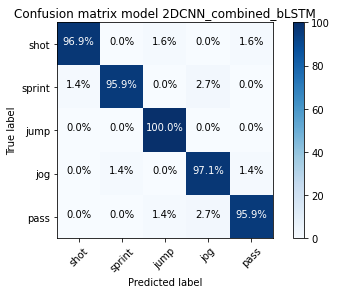

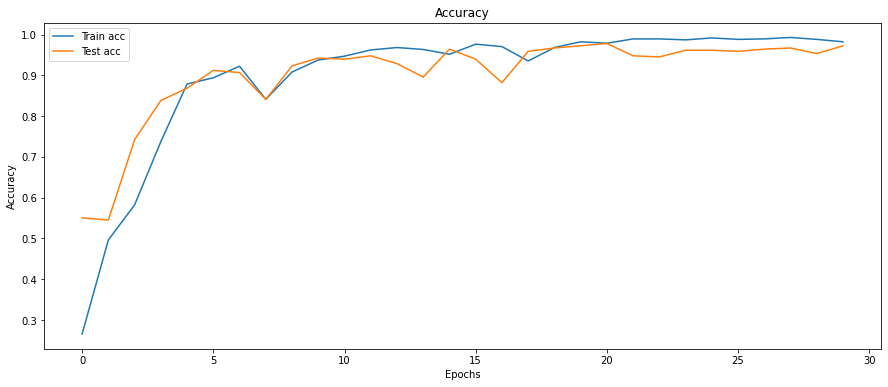

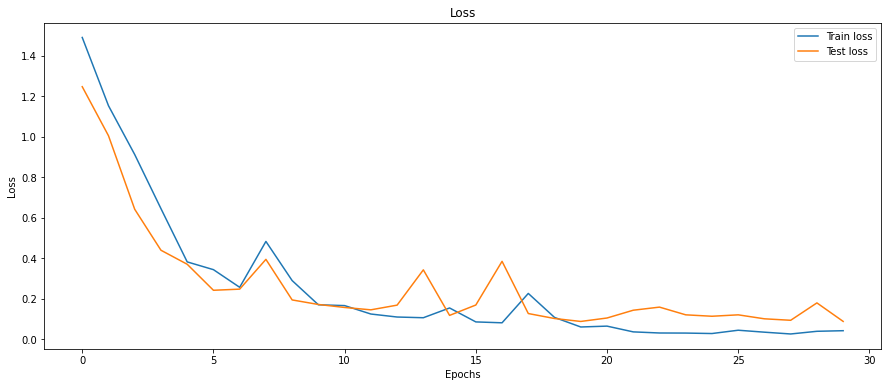

In [ ]:
selected_model = '2DCNN_combined_bLSTM'
model = trainModel(X, y, selected_model, model_function_names_CNN, model_function_names_RNN, epochs = 200, normalize = normalize)

In [ ]:
model.save('model.h5')